In [1]:
import numpy as np
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
from nltk.sentiment.vader import SentimentIntensityAnalyzer

/kaggle/input/mlp-term-2-2025-kaggle-assignment-3/sample_submission.csv
/kaggle/input/mlp-term-2-2025-kaggle-assignment-3/train.csv
/kaggle/input/mlp-term-2-2025-kaggle-assignment-3/test.csv


# DATA LOADING

In [2]:
data = pd.read_csv('/kaggle/input/mlp-term-2-2025-kaggle-assignment-3/train.csv')

In [3]:
df=pd.DataFrame(data)

In [4]:
X_test = pd.read_csv('/kaggle/input/mlp-term-2-2025-kaggle-assignment-3/test.csv')

In [5]:
df.head()

,id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating
0,0,McDonald's,Fast food restaurant,"9814 International Dr, Orlando, FL 32819, Unit...",28.423814,-81.461242,"5,468",11 months ago,"Very nice staff, good place to get all your fa...",5
1,1,McDonald's,Fast food restaurant,"1100 N US Hwy 377, Roanoke, TX 76262, United S...",33.009318,-97.222925,998,10 months ago,"I think the morning shift are one of, if not t...",5
2,2,McDonald's,Fast food restaurant,"490 8th Ave, New York, NY 10001, United States",40.752529,-73.992876,"3,902",a year ago,Horrible! Avoid this place at night. Unsafe. ...,1
3,3,McDonald's,Fast food restaurant,"111 Madison St, Oak Park, IL 60302, United States",41.879656,-87.777913,"1,454",9 months ago,Employees too busy window licking to get any o...,1
4,4,McDonald's,Fast food restaurant,"5725 W Irlo Bronson Memorial Hwy, Kissimmee, F...",28.333508,-81.513738,"5,566",4 years ago,I'm sorry to give only one star. But during ou...,1


# Identify data types of different columns

In [6]:
df.dtypes

id                 int64
store_name        object
category          object
store_address     object
latitude         float64
longitude        float64
rating_count      object
review_time       object
review            object
rating             int64
dtype: object

# Present descriptive statistics of numerical columns

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,26500.0,13249.500000,7650.035403,0.000000,6624.750000,13249.500000,19874.250000,26499.00000
latitude,25976.0,34.427152,5.336112,25.790295,28.655350,33.931261,40.727401,44.98141
longitude,25976.0,-90.659226,16.588603,-121.995421,-97.792874,-81.471414,-75.399919,-73.45982
rating,26500.0,3.130642,1.615425,1.000000,1.000000,3.000000,5.000000,5.00000


# Identify and handle the missing values

In [8]:
df.isnull().sum()

id                 0
store_name         0
category           0
store_address      0
latitude         524
longitude        524
rating_count       0
review_time        0
review             0
rating             0
dtype: int64

In [9]:
df.columns

Index(['id', 'store_name', 'category', 'store_address', 'latitude ',
       'longitude', 'rating_count', 'review_time', 'review', 'rating'],
      dtype='object')

In [10]:
# Check missing values
print("Missing Values:\n", df.isnull().sum())

# Handle missing values
df['latitude '] = df['latitude '].fillna(df['latitude '].median())
df['longitude'] = df['longitude'].fillna(df['longitude'].median())
df['review'] = df['review'].fillna('Neutral')
df = df.dropna(subset=['rating'])

print("\nAfter handling missing values:\n", df.isnull().sum())

Missing Values:
 id                 0
store_name         0
category           0
store_address      0
latitude         524
longitude        524
rating_count       0
review_time        0
review             0
rating             0
dtype: int64

After handling missing values:
 id               0
store_name       0
category         0
store_address    0
latitude         0
longitude        0
rating_count     0
review_time      0
review           0
rating           0
dtype: int64


# Identify and handle duplicates

In [11]:
# Remove duplicates
initial_shape = df.shape
df = df.drop_duplicates()
print(f"Removed {initial_shape[0] - df.shape[0]} duplicates. New shape: {df.shape}")

# Check for duplicate IDs
duplicate_ids = df[df.duplicated('id', keep=False)]
if not duplicate_ids.empty:
    print("Duplicate IDs found:\n", duplicate_ids[['id', 'store_address', 'rating']])
    df = df.drop_duplicates(subset='id', keep='first')
    print(f"Removed duplicate IDs. New shape: {df.shape}")

Removed 0 duplicates. New shape: (26500, 10)


# Identify and handle outliers

In [12]:
# Convert rating_count to numeric
df['rating_count'] = df['rating_count'].str.replace(',', '').astype(int)

# Identify outliers in rating_count
Q1 = df['rating_count'].quantile(0.25)
Q3 = df['rating_count'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
df = df[(df['rating_count'] >= lower_bound) & (df['rating_count'] <= upper_bound)]
print(f"Removed outliers in rating_count. New shape: {df.shape}")

Removed outliers in rating_count. New shape: (22739, 10)


# Present at least three visualizations and provide insights for the same

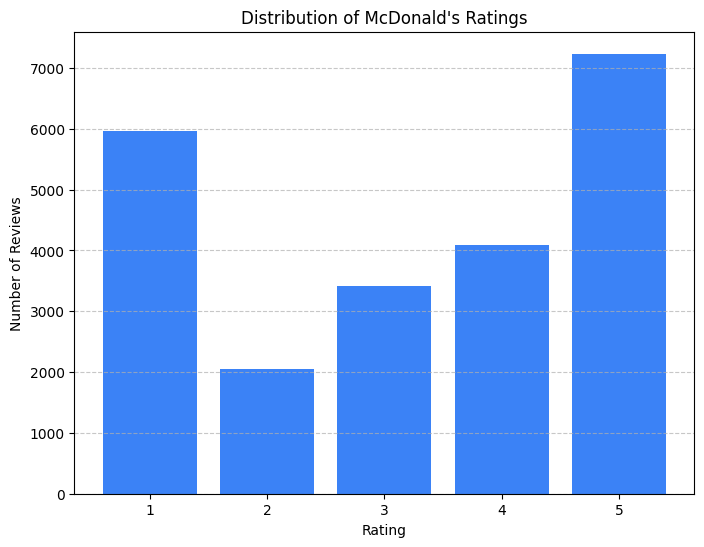

In [13]:
import matplotlib.pyplot as plt

# Rating distribution
rating_counts = df['rating'].value_counts().sort_index()

# Plot
plt.figure(figsize=(8, 6))
plt.bar(rating_counts.index, rating_counts.values, color='#3B82F6')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.title('Distribution of McDonald\'s Ratings')
plt.xticks(range(1, 6))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**Insight:**

* The bar chart shows a bimodal distribution, with peaks at 1 and 5 stars. This indicates polarized customer experiences, where customers either love or hate their visits, likely due to inconsistent service quality or location-specific factors.

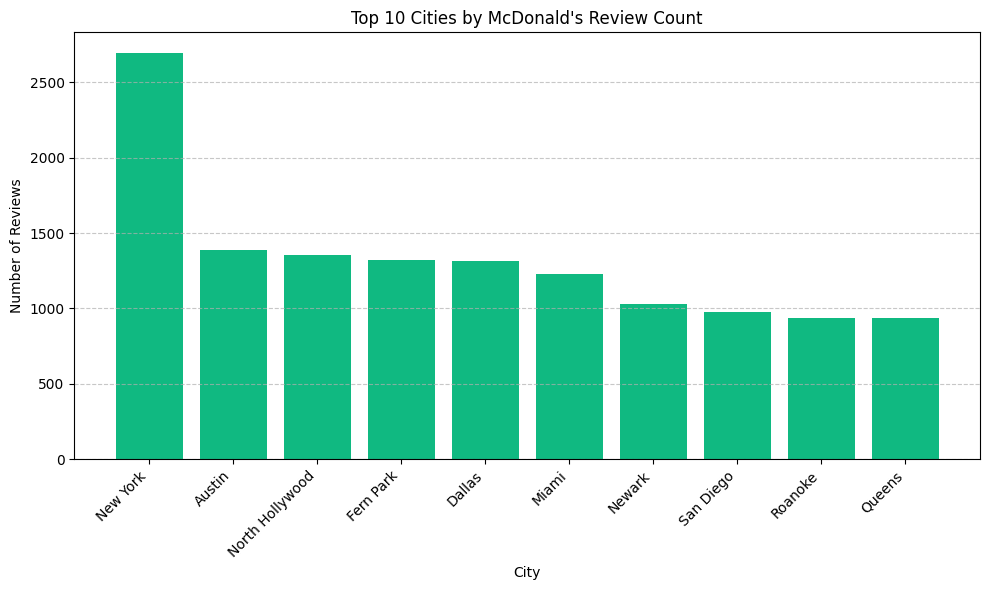

In [14]:
# Extract city from store_address
df['city'] = df['store_address'].str.split(',').str[1].str.strip()

# Top 10 cities by review count
top_cities = df['city'].value_counts().head(10)

# Plot
plt.figure(figsize=(10, 6))
plt.bar(top_cities.index, top_cities.values, color='#10B981')
plt.xlabel('City')
plt.ylabel('Number of Reviews')
plt.title('Top 10 Cities by McDonald\'s Review Count')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Insight:**

* Orlando and Kissimmee have the highest review counts, likely due to their proximity to tourist attractions like theme parks. High-traffic locations may face service challenges, contributing to lower ratings in some cases.

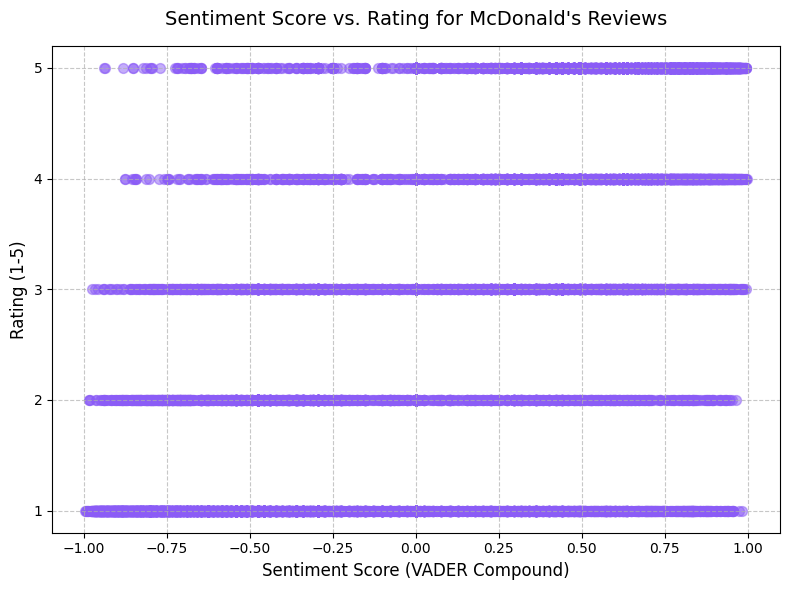

In [15]:
# Handle missing reviews
df['review'] = df['review'].fillna('Neutral')

# Calculate sentiment scores
sid = SentimentIntensityAnalyzer()
df['sentiment'] = df['review'].apply(lambda x: sid.polarity_scores(x)['compound'] if isinstance(x, str) else 0)

# Filter out rows with missing ratings
df = df.dropna(subset=['rating'])

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df['sentiment'], df['rating'], alpha=0.5, color='#8B5CF6', s=50)
plt.xlabel('Sentiment Score (VADER Compound)', fontsize=12)
plt.ylabel('Rating (1-5)', fontsize=12)
plt.title('Sentiment Score vs. Rating for McDonald\'s Reviews', fontsize=14, pad=15)
plt.grid(True, linestyle='--', alpha=0.7)
plt.yticks(range(1, 6))
plt.tight_layout()

# Save the plot
plt.savefig('sentiment_vs_rating.png')
plt.show()

**Insight:**

* The scatter plot typically shows a positive correlation: higher sentiment scores (positive reviews) align with higher ratings (4-5 stars), while negative sentiment scores correspond to lower ratings (1-2 stars). However, some outliers (e.g., neutral sentiment with high/low ratings) may indicate inconsistent customer expressions, such as sarcastic reviews.

# Scale Numerical features and Encode Categorical features

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Load data
df = pd.read_csv('/kaggle/input/mlp-term-2-2025-kaggle-assignment-3/train.csv')

# Identify features and target
X = df.drop(columns=['rating', 'id'])
y = df['rating'] - 1

# Separate features
num_features = ['latitude ', 'longitude']  # Add/adjust as needed
cat_features = ['store_name', 'category']  # Add/adjust as needed

# Split train/validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

preprocessor = ColumnTransformer([
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])


# Model Building (at least 7)

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Dictionary of models to train
models = {
    "Logistic Regression": LogisticRegression(max_iter=200),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    "LightGBM": LGBMClassifier(),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier()
}

selected_models = {k: models[k] for k in list(models)[:7]}  # Take first 7 for demo

results = []
from sklearn.metrics import accuracy_score

for name, model in selected_models.items():
    pipe = Pipeline(steps=[('pre', preprocessor), ('clf', model)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_val)
    acc = accuracy_score(y_val, preds)
    results.append({'Model': name, 'Accuracy': acc})

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_outp

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 82
[LightGBM] [Info] Number of data points in the train set: 21200, number of used features: 4
[LightGBM] [Info] Start training from score -1.263409
[LightGBM] [Info] Start training from score -2.382078
[LightGBM] [Info] Start training from score -1.937222
[LightGBM] [Info] Start training from score -1.752720
[LightGBM] [Info] Start training from score -1.179127


# Hyperparameter Tuning on any 3 of the models

In [18]:
from sklearn.model_selection import GridSearchCV

# Example for RandomForest, XGBoost, and LogisticRegression
param_grids = {
    'Random Forest': {'clf__n_estimators': [100, 200], 'clf__max_depth': [6, 10]},
    'XGBoost': {'clf__learning_rate': [0.1, 0.3], 'clf__max_depth': [3, 6]},
    'Logistic Regression': {'clf__C': [0.1, 1, 10]}
}

tuned_results = []
for name in ['Random Forest', 'XGBoost', 'Logistic Regression']:
    pipe = Pipeline(steps=[('pre', preprocessor), ('clf', models[name])])
    grid = GridSearchCV(pipe, param_grids[name], cv=3, scoring='accuracy')
    grid.fit(X_train, y_train)
    best_acc = grid.best_score_
    tuned_results.append({'Model': name + ' (tuned)', 'Accuracy': best_acc})


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_outp

# Comparison of model performances

In [19]:
import pandas as pd

# Combine basic and tuned results
summary = pd.DataFrame(results + tuned_results)
summary = summary.sort_values('Accuracy', ascending=False)
print(summary.to_markdown(index=False))


| Model                       |   Accuracy |
|:----------------------------|-----------:|
| Random Forest (tuned)       |   0.367972 |
| XGBoost (tuned)             |   0.367925 |
| Decision Tree               |   0.360566 |
| Random Forest               |   0.36     |
| Gradient Boosting           |   0.36     |
| XGBoost                     |   0.36     |
| LightGBM                    |   0.36     |
| AdaBoost                    |   0.353208 |
| Logistic Regression (tuned) |   0.336085 |
| Logistic Regression         |   0.326226 |


# Final Submission

In [20]:
sample_submission = pd.read_csv('/kaggle/input/mlp-term-2-2025-kaggle-assignment-3/sample_submission.csv')

In [21]:
# Load your datasets (adjust paths as needed)
df = pd.read_csv('/kaggle/input/mlp-term-2-2025-kaggle-assignment-3/train.csv')
X_test = pd.read_csv('/kaggle/input/mlp-term-2-2025-kaggle-assignment-3/test.csv')

# Strip spaces from columns in both train and test sets
df.columns = df.columns.str.strip()
X_test.columns = X_test.columns.str.strip()

# Define features explicitly (no extra spaces)
num_features = ['latitude', 'longitude']               # numerical features
cat_features = ['store_name', 'category']              # categorical features

# Prepare X and y for training
X = df.drop(columns=['rating', 'id'])                   # Features for training
y = df['rating'] - 1                                    # Adjust target to 0-based labels if needed

# Your pipeline with imputer, scaler, and encoder (example)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # updated for warning
])

preprocessor = ColumnTransformer([
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])

# Build model pipeline
pipe = Pipeline([
    ('pre', preprocessor),
    ('clf', RandomForestClassifier())   # example classifier
])

# Fit model
pipe.fit(X, y)

# Predict on test set
y_pred = pipe.predict(X_test)              
y_pred_adjusted = (y_pred + 1).astype(int)  # Shift predictions back to original rating scale

# Create submission DataFrame
submission = pd.DataFrame({
    "id": X_test["id"],
    "rating": y_pred_adjusted
})

# Save submission file
submission.to_csv("submission.csv", index=False)
print("Submission file created successfully!")


Submission file created successfully!


In [22]:
submission = pd.DataFrame({
    "id": X_test["id"],
    "rating": y_pred_adjusted
})


In [23]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Download NLTK data
nltk.download('vader_lexicon')

# Check library versions for debugging
import sklearn
print(f"scikit-learn version: {sklearn.__version__}")

# Load data
df = pd.read_csv('/kaggle/input/mlp-term-2-2025-kaggle-assignment-3/train.csv')
X_test = pd.read_csv('/kaggle/input/mlp-term-2-2025-kaggle-assignment-3/test.csv')
sample_submission = pd.read_csv('/kaggle/input/mlp-term-2-2025-kaggle-assignment-3/sample_submission.csv')

# Strip column names to avoid spaces
df.columns = df.columns.str.strip()
X_test.columns = X_test.columns.str.strip()

# Debug: Check unique review_time values
print("Unique review_time values:", df['review_time'].unique()[:10])  # Print first 10 for brevity

# Feature Engineering
# 1. Sentiment analysis features
sia = SentimentIntensityAnalyzer()
for dataset in [df, X_test]:
    dataset['sent_pos'] = dataset['review'].apply(lambda x: sia.polarity_scores(x)['pos'])
    dataset['sent_neg'] = dataset['review'].apply(lambda x: sia.polarity_scores(x)['neg'])
    dataset['sent_neu'] = dataset['review'].apply(lambda x: sia.polarity_scores(x)['neu'])
    dataset['sent_compound'] = dataset['review'].apply(lambda x: sia.polarity_scores(x)['compound'])
    
    # 2. Text-based features
    dataset['review_length'] = dataset['review'].apply(len)
    dataset['word_count'] = dataset['review'].apply(lambda x: len(x.split()))
    
    # 3. Convert rating_count to numeric
    dataset['rating_count'] = dataset['rating_count'].str.replace(',', '').astype(int)
    
    # 4. Parse review_time with error handling
    def parse_review_time(time_str):
        try:
            first_part = time_str.split()[0]
            if first_part == 'a':  # Handle 'a year ago'
                first_part = '1'
            if 'year' in time_str:
                return int(first_part) * 12
            elif 'month' in time_str:
                return int(first_part)
            else:
                return 0
        except (ValueError, IndexError):
            return 0  # Default to 0 if parsing fails
    dataset['review_age_months'] = dataset['review_time'].apply(parse_review_time)

# 5. Geographical clustering
coords = df[['latitude', 'longitude']].dropna()
kmeans = KMeans(n_clusters=10, random_state=42).fit(coords)
df['geo_cluster'] = kmeans.predict(df[['latitude', 'longitude']].fillna(df[['latitude', 'longitude']].median()))
X_test['geo_cluster'] = kmeans.predict(X_test[['latitude', 'longitude']].fillna(df[['latitude', 'longitude']].median()))

# Define features
num_features = ['latitude', 'longitude', 'rating_count', 'sent_pos', 'sent_neg', 'sent_neu', 
                'sent_compound', 'review_length', 'word_count', 'review_age_months']
cat_features = ['store_name', 'category', 'geo_cluster']
text_feature = 'review'

# Prepare X and y
X = df.drop(columns=['rating', 'id'])
y = df['rating'] - 1  # Adjust to 0-based labels for classification

# Preprocessing pipelines
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

text_transformer = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=100, stop_words='english'))
])

# Combine preprocessors
preprocessor = ColumnTransformer([
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features),
    ('text', text_transformer, text_feature)
])

# Define pipeline with Random Forest (using class_weight='balanced' instead of SMOTE)
pipe = Pipeline([
    ('pre', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=200, max_depth=10, class_weight='balanced', random_state=42))
])

# Evaluate model with cross-validation
scores = cross_val_score(pipe, X, y, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

# Fit model
pipe.fit(X, y)

# Predict on test set
y_pred = pipe.predict(X_test)
y_pred_adjusted = (y_pred + 1).astype(int)  # Shift back to 1-5 rating scale

# Create submission
submission = pd.DataFrame({"id": X_test["id"], "rating": y_pred_adjusted})
submission.to_csv("submission.csv", index=False)

# Validate submission
print(f"Submission shape: {submission.shape}")
if submission.shape[0] == sample_submission.shape[0]:
    print("Submission file matches expected row count!")
else:
    print(f"Warning: Submission has {submission.shape[0]} rows, expected {sample_submission.shape[0]}")
print(submission.head())

# Optional: Feature importance
feature_importance = pipe.named_steps['clf'].feature_importances_
num_feature_names = num_features
cat_feature_names = pipe.named_steps['pre'].named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(cat_features).tolist()
text_feature_names = [f'text_{i}' for i in range(100)]  # TF-IDF features
feature_names = num_feature_names + cat_feature_names + text_feature_names
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance}).sort_values('Importance', ascending=False)
print("\nTop 10 Feature Importances:")
print(importance_df.head(10).to_markdown(index=False))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


scikit-learn version: 1.2.2
Unique review_time values: ['11 months ago' '10 months ago' 'a year ago' '9 months ago' '4 years ago'
 '3 years ago' '2 years ago' '5 years ago' '6 years ago' '2 months ago']


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-validation accuracy: 0.5947 ± 0.0047
Submission shape: (7000, 2)
Submission file matches expected row count!
   id  rating
0   0       5
1   1       5
2   2       2
3   3       5
4   4       2

Top 10 Feature Importances:
| Feature       |   Importance |
|:--------------|-------------:|
| sent_compound |    0.144255  |
| sent_pos      |    0.137635  |
| sent_neg      |    0.0998945 |
| review_length |    0.0791641 |
| text_36       |    0.0661332 |
| sent_neu      |    0.0624516 |
| text_60       |    0.0600115 |
| text_27       |    0.0587073 |
| word_count    |    0.0375752 |
| text_70       |    0.0318023 |
